# Investigating the Impact of Entropy Regularisation on an Attention Augmented Agent

Author: Daniel Maguire

The code used to create these experiments is built upon the following implementations:

**Attention Augmented RL Agent**
https://github.com/cjlovering/Towards-Interpretable-Reinforcement-Learning-Using-Attention-Augmented-Agents-Replication


**Attention Map Visualisation**
https://github.com/greydanus/visualize_atari


**A2C PPO Working Implementation**
https://github.com/rgilman33/simple-A2C-PPO


#Experiment Name

In [ ]:
experiment_name = "Attention_BR_10m_steps_ent_decay_0.01_to_0.001_RUN1"

#Setup

## Hyperparameters

In [ ]:
#Number of trajectories/synchronous workers learning at the same time
n_envs = 72
#Number of steps in each trajectory
n_steps = 256

In [ ]:
is_dynamic_heads_model = False

In [ ]:
save_attention_map_before_training = True

### Environment Config

In [ ]:
env_name = 'Breakout-v4'
#env_name = 'Seaquest-v4'
#env_name = 'SpaceInvaders-v4'

### Entropy Settings

In [ ]:
entropy_coef = 0.01 #Constant for entropy if decay is set to False

enable_entropy_decay = True
entropy_coef_start = 0.01  #Starting value of entropy
entropy_coef_end = 0.001   #Ending value of entropy
entropy_decay = 0.995     #Decay rate of entropy

entropy_decay_type='logarithmic'  #'exponential', 'logarithmic', 'stepwise'
step_decay_interval=50  #interval for stepwise decay,
custom_filename = ""

### Training Hyperparameters

In [ ]:
from datetime import datetime
import os

if is_dynamic_heads_model:
  lr = 1e-4
  n_opt_epochs = 1 #Adjusting to 1 as Dynamic heads paper uses A2C which does not make use of opt epochs
else:
  lr = 5e-4 #Found that this was a decent learning rate for these experiments
  n_opt_epochs = 3

n_obs_per_round = n_envs * n_steps;
#num of steps
target_n_obs = 20000
n_minibatches = 8
bs = n_obs_per_round // n_minibatches
n_rounds = target_n_obs // n_obs_per_round

save_attention_map_interval = 3_000_000

accumulation_steps = 1

value_loss_coef = .5

current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
logs_dir_path = "log/log_" + str(env_name) + "_" + str(current_time)
if not os.path.exists(logs_dir_path):
    os.makedirs(logs_dir_path)  #Creates log directory

n_obs_per_round, n_rounds, bs

(18432, 1, 2304)

In [ ]:
attention_head_1, attention_head_2, attention_head_3, attention_head_4 =[],[],[],[]
r2_scores, entropies, entropy_coefs, value_losses, policy_losses, a2c_losses, value_targets_list, value_predictions_list = [], [], [], [], [], [], [], []
history_hx, history_cx = [], []

### Logging Config

In [ ]:
print_logs = False
print_model_logs = False
print_saliency_maps = False

## Dependencies

In [ ]:
import numpy as np
import torch
from torch.optim import RMSprop
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import tempfile
import torch
import numpy as np
import matplotlib.pyplot as plt
import csv
from matplotlib import colormaps

In [ ]:
!pip install torchlens

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 3.6 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !apt-get install -y xvfb
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/xvfb -O ../xvfb
    !pip install -q gymnasium[atari,accept-rom-license]
    !pip install -q tensorboardX
    !touch .setup_complete

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

In [ ]:
try:
    from stable_baselines3.common.env_util import make_vec_env
except:
    !pip install stable_baselines3
    from stable_baselines3.common.env_util import make_vec_env

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
log_file = os.path.join(logs_dir_path, "training_log.csv")

if not os.path.exists(logs_dir_path):
    os.makedirs(logs_dir_path)

with open(log_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Step", "Entropy", "Policy Loss", "Value Loss", "A2C Loss", "Value Target", "Value Prediction", "Reward", "Loss"])

def log_to_csv(step, entropy, policy_loss, value_loss, a2c_loss, value_target, value_prediction, avg_score=None, loss=None):
    with open(log_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        row = [step, entropy, policy_loss, value_loss, a2c_loss, value_target, value_prediction, avg_score, loss]
        writer.writerow(row)

def update_last_csv_line(avg_score, loss):
    with open(log_file, mode='r') as file:
        rows = list(csv.reader(file))

    if rows:
        rows[-1][-2] = avg_score
        rows[-1][-1] = loss

    with open(log_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(rows)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

In [ ]:
try:
    from procgen import ProcgenEnv
except:
    !pip install procgen
    from procgen import ProcgenEnv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: imageio-ffmpeg
    Found existing installation: imageio-ffmpeg 0.5.1
    Uninstalling imageio-ffmpeg-0.5.1:
      Successfully uninstalled imageio-ffmpeg-0.5.1


In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'; print(device)
if device != 'cuda': print("No cuda detected.")

cuda


## Utils

In [ ]:
import shutil
import os
from google.colab import drive
from IPython import get_ipython
from datetime import datetime

!pip install -q ipython
def copy_folders_to_drive(src_dir, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for item in os.listdir(src_dir):
        src_item_path = os.path.join(src_dir, item)
        dest_item_path = os.path.join(dest_dir, item)

        if os.path.isdir(src_item_path):
            shutil.copytree(src_item_path, dest_item_path)

current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

src_directory = '/content/log'
save_dir_name = current_time + "_" + experiment_name
dest_directory = f'/content/drive/My Drive/{save_dir_name}'
print(f"Destination Dir: {dest_directory}")

Destination Dir: /content/drive/My Drive/20240825_012524_Attention_BR_10m_steps_ent_decay_0.01_to_0.001_RUN1


In [ ]:
import contextlib
import os
from abc import ABC, abstractmethod
import numpy as np
from gym import spaces
import time
from collections import deque
import torch


"""
Copy-pasted from OpenAI to obviate dependency on Baselines. Required for vectorized environments.
"""

class AlreadySteppingError(Exception):
    """
    Raised when an asynchronous step is running while
    step_async() is called again.
    """

    def __init__(self):
        msg = 'already running an async step'
        Exception.__init__(self, msg)


class NotSteppingError(Exception):
    """
    Raised when an asynchronous step is not running but
    step_wait() is called.
    """

    def __init__(self):
        msg = 'not running an async step'
        Exception.__init__(self, msg)


class VecEnv(ABC):
    """
    An abstract asynchronous, vectorized environment.
    Used to batch data from multiple copies of an environment, so that
    each observation becomes an batch of observations, and expected action is a batch of actions to
    be applied per-environment.
    """
    closed = False
    viewer = None

    metadata = {
        'render.modes': ['human', 'rgb_array']
    }

    def __init__(self, num_envs, observation_space, action_space):
        self.num_envs = num_envs
        self.observation_space = observation_space
        self.action_space = action_space

    @abstractmethod
    def reset(self):
        """
        Reset all the environments and return an array of
        observations, or a dict of observation arrays.

        If step_async is still doing work, that work will
        be cancelled and step_wait() should not be called
        until step_async() is invoked again.
        """
        pass

    @abstractmethod
    def step_async(self, actions):
        """
        Tell all the environments to start taking a step
        with the given actions.
        Call step_wait() to get the results of the step.

        You should not call this if a step_async run is
        already pending.
        """
        pass

    @abstractmethod
    def step_wait(self):
        """
        Wait for the step taken with step_async().

        Returns (obs, rews, dones, infos):
         - obs: an array of observations, or a dict of
                arrays of observations.
         - rews: an array of rewards
         - dones: an array of "episode done" booleans
         - infos: a sequence of info objects
        """
        pass

    def close_extras(self):
        """
        Clean up the  extra resources, beyond what's in this base class.
        Only runs when not self.closed.
        """
        pass

    def close(self):
        if self.closed:
            return
        if self.viewer is not None:
            self.viewer.close()
        self.close_extras()
        self.closed = True

    def step(self, actions):
        """
        Step the environments synchronously.

        This is available for backwards compatibility.
        """
        self.step_async(actions)
        return self.step_wait()

    def render(self, mode='human'):
        imgs = self.get_images()
        bigimg = "ARGHH" #tile_images(imgs)
        if mode == 'human':
            self.get_viewer().imshow(bigimg)
            return self.get_viewer().isopen
        elif mode == 'rgb_array':
            return bigimg
        else:
            raise NotImplementedError

    def get_images(self):
        """
        Return RGB images from each environment
        """
        raise NotImplementedError

    @property
    def unwrapped(self):
        if isinstance(self, VecEnvWrapper):
            return self.venv.unwrapped
        else:
            return self

    def get_viewer(self):
        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.SimpleImageViewer()
        return self.viewer


class VecEnvWrapper(VecEnv):
    """
    An environment wrapper that applies to an entire batch
    of environments at once.
    """

    def __init__(self, venv, observation_space=None, action_space=None):
        self.venv = venv
        super().__init__(num_envs=venv.num_envs,
                        observation_space=observation_space or venv.observation_space,
                        action_space=action_space or venv.action_space)

    def step_async(self, actions):
        self.venv.step_async(actions)

    @abstractmethod
    def reset(self):
        pass

    @abstractmethod
    def step_wait(self):
        pass

    def close(self):
        return self.venv.close()

    def render(self, mode='human'):
        return self.venv.render(mode=mode)

    def get_images(self):
        return self.venv.get_images()

    def __getattr__(self, name):
        if name.startswith('_'):
            raise AttributeError("attempted to get missing private attribute '{}'".format(name))
        return getattr(self.venv, name)


class VecEnvObservationWrapper(VecEnvWrapper):
    @abstractmethod
    def process(self, obs):
        pass

    def reset(self):
        obs = self.venv.reset()
        return self.process(obs)

    def step_wait(self):
        obs, rews, dones, infos = self.venv.step_wait()
        return self.process(obs), rews, dones, infos


class CloudpickleWrapper(object):
    """
    Uses cloudpickle to serialize contents (otherwise multiprocessing tries to use pickle)
    """

    def __init__(self, x):
        self.x = x

    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps(self.x)

    def __setstate__(self, ob):
        import pickle
        self.x = pickle.loads(ob)


@contextlib.contextmanager
def clear_mpi_env_vars():
    """
    from mpi4py import MPI will call MPI_Init by default.  If the child process has MPI environment variables, MPI will think that the child process is an MPI process just like the parent and do bad things such as hang.
    This context manager is a hacky way to clear those environment variables temporarily such as when we are starting multiprocessing
    Processes.
    """
    removed_environment = {}
    for k, v in list(os.environ.items()):
        for prefix in ['OMPI_', 'PMI_']:
            if k.startswith(prefix):
                removed_environment[k] = v
                del os.environ[k]
    try:
        yield
    finally:
        os.environ.update(removed_environment)


class VecFrameStack(VecEnvWrapper):
    def __init__(self, venv, nstack):
        self.venv = venv
        self.nstack = nstack
        wos = venv.observation_space  # wrapped ob space
        low = np.repeat(wos.low, self.nstack, axis=-1)
        high = np.repeat(wos.high, self.nstack, axis=-1)
        self.stackedobs = np.zeros((venv.num_envs,) + low.shape, low.dtype)
        observation_space = spaces.Box(low=low, high=high, dtype=venv.observation_space.dtype)
        VecEnvWrapper.__init__(self, venv, observation_space=observation_space)

    def step_wait(self):
        obs, rews, news, infos = self.venv.step_wait()
        self.stackedobs = np.roll(self.stackedobs, shift=-1, axis=-1)
        for (i, new) in enumerate(news):
            if new:
                self.stackedobs[i] = 0
        self.stackedobs[..., -obs.shape[-1]:] = obs
        return self.stackedobs, rews, news, infos

    def reset(self):
        obs = self.venv.reset()
        self.stackedobs[...] = 0
        self.stackedobs[..., -obs.shape[-1]:] = obs
        return self.stackedobs

class VecExtractDictObs(VecEnvObservationWrapper):
    def __init__(self, venv, key):
        self.key = key
        super().__init__(venv=venv,
            observation_space=venv.observation_space.spaces[self.key])

    def process(self, obs):
        return obs[self.key]


class RunningMeanStd(object):
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        self.mean, self.var, self.count = update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count)


def update_mean_var_count_from_moments(mean, var, count, batch_mean, batch_var, batch_count):
    delta = batch_mean - mean
    tot_count = count + batch_count

    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + np.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count


class VecNormalize(VecEnvWrapper):
    """
    A vectorized wrapper that normalizes the observations
    and returns from an environment.
    """

    def __init__(self, venv, ob=True, ret=True, clipob=10., cliprew=10., gamma=0.99, epsilon=1e-8):
        VecEnvWrapper.__init__(self, venv)

        self.ob_rms = RunningMeanStd(shape=self.observation_space.shape) if ob else None
        self.ret_rms = RunningMeanStd(shape=()) if ret else None

        self.clipob = clipob
        self.cliprew = cliprew
        self.ret = np.zeros(self.num_envs)
        self.gamma = gamma
        self.epsilon = epsilon

    def step_wait(self):
        obs, rews, news, infos = self.venv.step_wait()
        self.ret = self.ret * self.gamma + rews
        obs = self._obfilt(obs)
        if self.ret_rms:
            self.ret_rms.update(self.ret)
            rews = np.clip(rews / np.sqrt(self.ret_rms.var + self.epsilon), -self.cliprew, self.cliprew)
        self.ret[news] = 0.
        return obs, rews, news, infos

    def _obfilt(self, obs):
        if self.ob_rms:
            self.ob_rms.update(obs)
            obs = np.clip((obs - self.ob_rms.mean) / np.sqrt(self.ob_rms.var + self.epsilon), -self.clipob, self.clipob)
            return obs
        else:
            return obs

    def reset(self):
        self.ret = np.zeros(self.num_envs)
        obs = self.venv.reset()
        return self._obfilt(obs)


class VecMonitor(VecEnvWrapper):
    def __init__(self, venv, filename=None, keep_buf=0, info_keywords=()):
        VecEnvWrapper.__init__(self, venv)
        self.eprets = None
        self.eplens = None
        self.epcount = 0
        self.tstart = time.time()

        self.results_writer = None
        self.info_keywords = info_keywords
        self.keep_buf = keep_buf
        if self.keep_buf:
            self.epret_buf = deque([], maxlen=keep_buf)
            self.eplen_buf = deque([], maxlen=keep_buf)

    def reset(self):
        obs = self.venv.reset()
        self.eprets = np.zeros(self.num_envs, 'f')
        self.eplens = np.zeros(self.num_envs, 'i')
        return obs

    def step_wait(self):
        obs, rews, dones, infos = self.venv.step_wait()
        self.eprets += rews
        self.eplens += 1

        newinfos = list(infos[:])
        for i in range(len(dones)):
            if dones[i]:
                info = infos[i].copy()
                ret = self.eprets[i]
                eplen = self.eplens[i]
                epinfo = {'r': ret, 'l': eplen, 't': round(time.time() - self.tstart, 6)}
                for k in self.info_keywords:
                    epinfo[k] = info[k]
                info['episode'] = epinfo
                if self.keep_buf:
                    self.epret_buf.append(ret)
                    self.eplen_buf.append(eplen)
                self.epcount += 1
                self.eprets[i] = 0
                self.eplens[i] = 0
                if self.results_writer:
                    self.results_writer.write_row(epinfo)
                newinfos[i] = info
        return obs, rews, dones, newinfos


def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n



""" Helpers """

def get_avg_score(epinfos):
    return np.array([e['r'] for e in epinfos]).mean()

# Hiding in here bc it's ugly. Surely better way to get from vecenvs shapes to desired experience replay shape.
# Quarantine fine for now.
def reshaping_processing_acrobatics(returns_, old_state_estimates_, old_action_probs_, actions_, frames_):

    returns_ = returns_.transpose(1,0);
    frames_ = frames_.transpose(1,0,2,3,4);
    actions_ = actions_.transpose(1,0)
    old_action_probs_ = np.array(old_action_probs_).transpose(1,0,2)
    old_state_estimates_ = old_state_estimates_.transpose(1,0,2)

    actions_ = actions_[..., None].reshape(-1)
    returns_ = returns_[..., None].reshape(-1)
    frames_ = frames_.reshape(-1, *frames_[0][0].shape);
    old_action_probs_ = old_action_probs_[..., None].reshape(-1, n_actions)
    old_state_estimates_ = old_state_estimates_.reshape(-1)

    returns_ = torch.FloatTensor(returns_).to('cpu')
    frames_ = np_to_pytorch_img(frames_) # this op takes forever, should do differently
    actions_ = torch.LongTensor(actions_).to('cpu')
    old_action_probs_ = torch.FloatTensor(old_action_probs_).to('cpu')
    old_state_estimates_ = torch.FloatTensor(old_state_estimates_).to('cpu')

    return returns_, old_state_estimates_, old_action_probs_, actions_, frames_

def np_to_pytorch_img(frame):
    frame = torch.FloatTensor(frame).permute(0,3,1,2) / 255.
    return frame

def pytorch_to_np_img(frame):
    return (frame * 255.).permute(0, 2, 3, 1).numpy().astype(int)

categorical = torch.distributions.categorical.Categorical

def get_action(action_probs, deterministic=False):
    p = action_probs.exp()
    if deterministic:
        m, ix = torch.max(p, dim=-1);
    else:
        ix = categorical(p).sample()
    return ix

def get_n_params(model):
    return str(np.round(np.array([p.numel() for p in model.parameters()]).sum() / 1e6, 3)) + ' M params'

def resize_observations(observations, new_shape=(160, 210)):
    if is_dynamic_heads_model:
        new_shape=(158, 206)
    else:
      new_shape=(84, 84)
    resized_observations = []
    for ob in observations:

        resized = cv2.resize(ob.squeeze(), new_shape, interpolation=cv2.INTER_AREA)
        try :
          resized = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)
        except:
          pass
        # Add the channel dimension back
        resized = resized[..., np.newaxis]
        #print(f"obs shape: {ob.shape}")
        #if len(ob.shape) == 3:
            #resized = resized[..., np.newaxis]  # Add the channel dimension back if it was originally there
        resized_observations.append(resized)
    return np.array(resized_observations)

## Environment Setup

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import GrayScaleObservation
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.env_util import make_atari_env
from gymnasium.experimental.wrappers.vector import ResizeObservationV0
from gymnasium.wrappers import ResizeObservation
import time

start_time = time.time()

env = make_vec_env(env_name, n_envs=n_envs, seed=0)
print(type(env))
print(f"env")
print("--------------------")
print(f"venv.observation_space: {env.observation_space}")
print(f"venv.observation_space type: {type(env.observation_space)}")
print(f"venv.observation_space BOX shape: {env.observation_space.shape}")
print(type(env))
print("--------------------")
env = VecMonitor(env)
print(type(env))
print("--------------------")
env = VecNormalize(env, ob=False)
print(type(env))
print("--------------------")

#print(f"reset:  {env.reset(seed=42)}")

env.reset()

print(f"env.action_space: {env.action_space}")
print(f"env.action_space TYPE: {type(env.action_space)}")
print(f"env.action_space.sample(): {env.action_space.sample()}")
print(f"env.observation_space.shape: {env.observation_space.shape}")

elapsed_time = time.time() - start_time
print(f"SB3 Elapsed time: {elapsed_time} seconds")
observations, rewards, dones, infos = env.step([env.action_space.sample() for _ in range(n_envs)])

print(f"observations.shape: {observations.shape}")
#print(observations)

resized_obs = resize_observations(observations, new_shape=(64, 64))
#resizing due to out of memory issues
print(f"Resized observations shape: {resized_obs.shape}")

n_actions = env.action_space.n
print(f"Number of actions: {n_actions}")

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
env
--------------------
venv.observation_space: Box(0, 255, (210, 160, 3), uint8)
venv.observation_space type: <class 'gymnasium.spaces.box.Box'>
venv.observation_space BOX shape: (210, 160, 3)
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
--------------------
<class '__main__.VecMonitor'>
--------------------
<class '__main__.VecNormalize'>
--------------------
env.action_space: Discrete(4)
env.action_space TYPE: <class 'gymnasium.spaces.discrete.Discrete'>
env.action_space.sample(): 3
env.observation_space.shape: (210, 160, 3)
SB3 Elapsed time: 28.369298219680786 seconds
observations.shape: (72, 210, 160, 3)
Resized observations shape: (72, 84, 84, 1)
Number of actions: 4


## Attention Entropy

Calculate the mean entropy for each head from the entropy dictionary.


In [ ]:
def calculate_mean_entropies(entropy_dict):
    mean_entropies = {}
    for head, entropies in entropy_dict.items():
        mean_entropies[head] = np.mean(entropies) if entropies else 0.0
    return mean_entropies

Calculate the entropy of attention weights and return a single entropy value representing the overall entropy across 72 workers.

In [ ]:
import numpy as np

def calculate_entropy(attention_weights):
    #print(attention_weights.shape)
    #Flatten the last dimension since it is always 1
    attention_weights = attention_weights.reshape(attention_weights.shape[:-1])
    epsilon = 1e-12
    attention_weights = np.clip(attention_weights, epsilon, 1. - epsilon)
    #Normalise attention weights
    attention_weights /= attention_weights.sum(axis=-1, keepdims=True)
    #Calculate entropy for each worker
    entropy = -np.sum(attention_weights * np.log(attention_weights), axis=-1)
    #Calculate average entropy across all workers and time steps
    average_entropy = np.mean(entropy)
    return average_entropy

## Entropy Coefficient Decay

In [ ]:
def adjust_entropy_coef(entropy_coef, episode, num_episodes):

      #print(entropy_coef_end)

      #entropy_coef = entropy_coef_end + (entropy_coef_start - entropy_coef_end) * np.log(episode + 1) / np.log(num_episodes)
      #print(f"got here")

      if entropy_decay_type == 'logarithmic':
          #Logarithmic decay
          #entropy_coef decreases slowly at first and then more rapidly
          entropy_coef = entropy_coef_end + (entropy_coef_start - entropy_coef_end) * (entropy_decay ** episode)
          #print(f"logarithmic")
      elif entropy_decay_type == 'exponential':
          #Exponential decay
          #entropy_coef decreases rapidly at first and then more slowly
          entropy_coef = entropy_coef_end + (entropy_coef_start - entropy_coef_end) * np.log(episode + 1) / np.log(num_episodes)
          print(f"entropy_coef {entropy_coef}")
          #print(f"exponential")
      elif entropy_decay_type == 'stepwise':
          #Stepwise decay
          #entropy_coef decreases in steps based on the step_decay_interval
          decay_steps = episode // step_decay_interval
          #print(f"stepwise")
          entropy_coef = max(entropy_coef_start * (entropy_decay ** decay_steps), entropy_coef_end)

      return entropy_coef

## Attention Map Logic

In [ ]:
from matplotlib import animation
import shutil
import imageio

def create_video_from_frames(directory_path, output_video_path, fps=8,):
    #Get list of all files in dir
    files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
    files.sort()

    frame = cv2.imread(os.path.join(directory_path, files[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for file in files:
        frame = cv2.imread(os.path.join(directory_path, file))
        video.write(frame)

    video.release()
    print(f"Video saved at {output_video_path}")


def generate_attention_maps(env_name, num_frames=100, save_dir="./", first_frame=100, resolution=75, density=5, radius=5, prefix='default', current_frame=None):
    print("\n Generating Attention Maps...\n")

    for head_index in range(4):
        head_dir = os.path.join(save_dir, f"head_{head_index+1}")
        if os.path.exists(head_dir):
            shutil.rmtree(head_dir)

    meta = get_env_meta(env_name)

    os.makedirs(save_dir, exist_ok=True)
    start = time.time()
    movie_title = "{}-{}-{}.mp4".format(prefix, num_frames, env_name.lower())
    FFMpegWriter = animation.writers['ffmpeg']
    metadata = dict(title=movie_title, artist='Daniel Maguire', comment='atari-attention-video')

    total_frames = len(frames)
    if print_saliency_maps:
      print(f"total frames: {total_frames}")


    for i in range(num_frames): #this skips every second frame so we see a bit more happening in the video
      if i % 4 == 0:  #Process only frames that are not skipped
        ix = first_frame + i
        if ix < total_frames:
            if print_saliency_maps:
              print(f"\n\n\n\n\nFrame {ix}")
              print(f"frames shape: {frames.shape}")
            frame = frames[ix].squeeze().numpy().copy()
            if print_saliency_maps:
              print(f"frame shape: {frame.shape}")
            #frame = preprocess_frame_saliency_display(frame)
            attention_saliencies = score_frame_multiple_heads(agent, None, ix, radius, density, interp_func=occlude, mode='actor')

            for head_index, attention_saliency in enumerate(attention_saliencies):
                head_dir = os.path.join(save_dir, f"head_{head_index+1}")
                os.makedirs(head_dir, exist_ok=True)
                if print_saliency_maps:
                  print(f"Attention Head {head_index+1}")

                attention_frame, S = saliency_on_atari_frame_multiple_heads([attention_saliency], frame, fudge_factor=meta['actor_ff'], channels=[1], name=f"Attention Saliency, Head {head_index+1}")

                #Display original Atari frame with overlaid saliency map
                if print_saliency_maps:
                  plt.figure(figsize=(10, 10))
                  plt.imshow(attention_frame, cmap='gray')
                  plt.imshow(S, cmap='hot', alpha=0.4)  #Overlay saliency map with alpha blending
                  plt.title(f"Saliency map head {head_index+1}")
                  #plt.savefig(logs_dir_path+"/saliency_video_frames")
                  frame_filename = os.path.join(head_dir, f"frame_{ix:04d}.png")
                  plt.savefig(frame_filename)
                  plt.show()
                  plt.close()
                else:
                  plt.figure(figsize=(10, 10))
                  plt.imshow(attention_frame, cmap='gray')
                  plt.imshow(S, cmap='hot', alpha=0.4)  #Overlay saliency map with alpha blending
                  plt.title(f"Saliency map head {head_index+1}")
                  #plt.savefig(logs_dir_path+"/saliency_video_frames")
                  frame_filename = os.path.join(head_dir, f"frame_{ix:04d}.png")
                  plt.savefig(frame_filename)
                  plt.close()
                  plt.close()
                  plt.close()
                  plt.close()
                  plt.close()
                  plt.close()
                  #Close the plot to free memory

            #plt.imshow(frame)
            #plt.title(env_name.lower(), fontsize=15)

            tstr = time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - start))
            print('\ttime: {} | progress: {:.1f}%'.format(tstr, 100*i/min(num_frames, total_frames)), end='\r')

    directories = ['head_1', 'head_2', 'head_3', 'head_4']
    output_videos = ['attention_head_1.mp4', 'attention_head_2.mp4', 'attention_head_3.mp4', 'attention_head_4.mp4']

    if current_frame is not None:
        attention_vid_dir = os.path.join(save_dir, f"frame_{current_frame}")
        os.makedirs(attention_vid_dir, exist_ok=True)
        for directory, output_video in zip(directories, output_videos):
            create_video_from_frames(save_dir+"/"+directory, attention_vid_dir+"/"+output_video)
    else:
        for directory, output_video in zip(directories, output_videos):
            create_video_from_frames(save_dir+"/"+directory, save_dir+"/"+output_video)
    print('\nfinished.')

In [ ]:
from torch.autograd import Variable
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.transform import resize

## Attention Map Visualisation Logic

def get_env_meta(env_name):
    meta = {}
    if env_name == "Breakout-v0" or env_name == "Breakout-v4" or env_name == "BreakoutNoFrameskip-v4" or env_name == "Breakout-v5":
        meta['critic_ff'] = 600
        meta['actor_ff'] = 300
    elif env_name == "SpaceInvaders-v0" or env_name == "SpaceInvaders-v4"  or env_name == "SpaceInvadersNoFrameskip-v4" or env_name == "SpaceInvaders-v5":
        meta['critic_ff'] = 400
        meta['actor_ff'] = 400
    elif env_name == "Seaquest-v0" or env_name == "Seaquest-v4" or env_name == "SeaquestNoFrameskip-v4" or env_name == "Seaquest-v5":
        meta['critic_ff'] = 400
        meta['actor_ff'] = 400
    else:
        print(f'environment "{env_name}" not supported')
    return meta


searchlight = lambda I, mask: I * mask + gaussian_filter(I, sigma=3) * (1 - mask)  # choose an area NOT to blur
occlude = lambda I, mask: I * (1 - mask) + gaussian_filter(I, sigma=3) * mask  # choose an area to blur

def plot_attention_weights(history, attention_head_index, num_steps=100):
    attention_weights = np.array(history[f'attention_head_{attention_head_index}'])
    steps = min(num_steps, len(attention_weights))

    fig, axs = plt.subplots(1, steps, figsize=(steps * 2, 2))
    for step in range(steps):
        ax = axs[step]
        ax.imshow(attention_weights[step][0], cmap='hot', interpolation='nearest')
        ax.axis('off')
        ax.set_title(f'Step {step+1}')
    plt.show()

def visualize_mask(mask, save_path):
    plt.figure(figsize=(6, 6))
    plt.imshow(mask, cmap='gray')
    plt.colorbar()
    plt.savefig(save_path)
    plt.close()

def get_mask(center, size, r):
    y, x = np.ogrid[-center[0]:size[0] - center[0], -center[1]:size[1] - center[1]]
    keep = x * x + y * y <= r * r
    mask = np.zeros(size)
    mask[keep] = 1  # select a circle of pixels
    mask = gaussian_filter(mask, sigma=r)  # blur the circle of pixels. this is a 2D Gaussian for r=r^2=1
    return mask / mask.max()


def saliency_on_atari_frame_multiple_heads(saliencies, atari, fudge_factor, channels, sigma=0, name=""):
    #saliencie: List of saliency maps for different heads
    #channels: List of channels to apply each saliency map
    pmax = max(saliency.max() for saliency in saliencies)
    #print(f"atari shape: {atari.shape}")
    if print_saliency_maps:
      print(f"atari shape: {atari.shape}")

    if atari.shape[0] == 3:
        atari = np.transpose(atari, (1, 2, 0))  #transpose if the channel is the first dimension

    #Create a figure for all the subplots
    plt.figure(figsize=(20, 10))

    #Plot the original Atari frame
    #plt.subplot(1, 4, 1)
    #plt.title('Original Atari Frame')
    #plt.imshow(atari)

    if atari.ndim == 2 or (atari.ndim == 3 and atari.shape[2] != 3):
        atari = np.expand_dims(atari, axis=-1)

    I = atari.astype(np.float32)


    for saliency, channel in zip(saliencies, channels):
        #Resize saliency to the size of Atari frame
        S = resize(saliency, (atari.shape[0], atari.shape[1]), mode='reflect', preserve_range=True).astype(np.float32)

        if sigma > 0:
            S = gaussian_filter(S, sigma=sigma)  #Apply Gaussian blur if sigma > 0

        S -= S.min()  #Normalize saliency map
        S = fudge_factor * pmax * S / S.max()  #Scale saliency map

        S = np.clip(S, 0, 255)  #Clip values to the range [0, 255]

        if I.shape[2] == 1:
            # If the image has a single channel, we simply add the saliency map to it
            I[:, :, 0] = np.clip(I[:, :, 0] + S, 0, 255)
        else:
            # Otherwise, add to the specified channel
            I[:, :, channel] = np.clip(I[:, :, channel] + S, 0, 255)

    I = I.astype(np.uint8)  #Convert image back to uint8
    '''
        #Display the original Atari frame with overlaid saliency map
        plt.figure(figsize=(10, 10))
        plt.imshow(atari)
        plt.imshow(S, cmap='hot', alpha=0.4)  #Overlay saliency map with alpha blending
        plt.title(name)
        plt.show()

        #plt.savefig(logs_dir_path+"/saliency_video_frames")
        plt.close()  # Close the plot to free memory
    '''
    return atari, S

def score_frame_multiple_heads(model, history, ix, r, d, interp_func, mode='actor'):
    assert mode in ['actor', 'critic'], 'mode must be either "actor" or "critic"'

    #Combining all attention heads into a single list for iteration
    attention_heads = [
        attention_head_1,
        attention_head_2,
        attention_head_3,
        attention_head_4
    ]
    #print(f"Number of attention heads: {len(attention_heads)}")

    saliencies = []
    for head_index in range(len(attention_heads)):
        L = run_through_attention_model(model, history, ix, interp_func, mask=None, mode=mode, head_index=head_index)
        scores = np.zeros((int(84 / d) + 1, int(84 / d) + 1))  # saliency scores S(t,i,j)
        for i in range(0, 84, d):
            for j in range(0, 84, d):
                mask = get_mask(center=[i, j], size=[84, 84], r=r)
                l = run_through_attention_model(model, history, ix, interp_func, mask=mask, mode=mode, head_index=head_index)
                scores[int(i / d), int(j / d)] = (L - l).pow(2).sum().mul_(.5).item()

        pmax = scores.max()
        scores = resize(scores, (84, 84), mode='reflect', preserve_range=True).astype(np.float32)
        saliencies.append(pmax * scores / scores.max())

    return saliencies

def run_through_attention_model(model, history, ix, interp_func=None, mask=None, blur_memory=None, mode='actor', head_index=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if mask is None:
        #im = preprocess_observation(history['ins'][ix])
        im = frames[ix]
        #print(f"im shape: {im.shape}")
    else:
        assert interp_func is not None, "interp func cannot be none"
        #im = interp_func(preprocess_observation(history['ins'][ix]).squeeze(), mask).reshape(1, 80, 80)  # perturb input I -> I'

        im = interp_func(frames[ix].squeeze(), mask).reshape(1, 84, 84)  # perturb input I -> I'
        #print(f"im shape: {im.shape}")

    tens_state = im.clone().detach().to(device).float()  # Convert to float

    state = Variable(tens_state.unsqueeze(0)).to(device)
    hx = Variable(torch.tensor(history_hx[ix-1], dtype=torch.float32).view(1, -1)).to(device)
    cx = Variable(torch.tensor(history_cx[ix-1], dtype=torch.float32).view(1, -1)).to(device)

    if blur_memory is not None:
        cx.mul_(1 - blur_memory)  # perturb memory vector

    state_values, action_score_logits, hidden_state, attention_maps = model((state))
    return attention_maps[head_index]

# Model Implementations

## Attention IMPALA Logic

### ConvLSTM

In [ ]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        """Initialize stateful ConvLSTM cell.

        Parameters
        ----------
        input_channels : ``int``
            Number of channels of input tensor.
        hidden_channels : ``int``
            Number of channels of hidden state.
        kernel_size : ``int``
            Size of the convolutional kernel.

        Paper
        -----
        https://papers.nips.cc/paper/5955-convolutional-lstm-network-a-machine-learning-approach-for-precipitation-nowcasting.pdf

        Referenced code
        ---------------
        https://github.com/automan000/Convolution_LSTM_PyTorch/blob/master/convolution_lstm.py
        """
        super(ConvLSTMCell, self).__init__()

        assert hidden_channels % 2 == 0

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_features = 4

        self.padding = int((kernel_size - 1) / 2)

        self.Wxi = nn.Conv2d(
            self.input_channels,
            self.hidden_channels,
            self.kernel_size,
            1,
            self.padding,
            bias=True,
        )
        self.Whi = nn.Conv2d(
            self.hidden_channels,
            self.hidden_channels,
            self.kernel_size,
            1,
            self.padding,
            bias=False,
        )
        self.Wxf = nn.Conv2d(
            self.input_channels,
            self.hidden_channels,
            self.kernel_size,
            1,
            self.padding,
            bias=True,
        )
        self.Whf = nn.Conv2d(
            self.hidden_channels,
            self.hidden_channels,
            self.kernel_size,
            1,
            self.padding,
            bias=False,
        )
        self.Wxc = nn.Conv2d(
            self.input_channels,
            self.hidden_channels,
            self.kernel_size,
            1,
            self.padding,
            bias=True,
        )
        self.Whc = nn.Conv2d(
            self.hidden_channels,
            self.hidden_channels,
            self.kernel_size,
            1,
            self.padding,
            bias=False,
        )
        self.Wxo = nn.Conv2d(
            self.input_channels,
            self.hidden_channels,
            self.kernel_size,
            1,
            self.padding,
            bias=True,
        )
        self.Who = nn.Conv2d(
            self.hidden_channels,
            self.hidden_channels,
            self.kernel_size,
            1,
            self.padding,
            bias=False,
        )

        self.Wci = None
        self.Wcf = None
        self.Wco = None

        self.prev_hidden = None

    def register_hooks(self, tensor, name):
        def hook(grad):
            print(f"Gradient for {name}: {grad}")
        tensor.register_hook(hook)

    def forward(self, x):
        if print_model_logs : print(f"[ConvLSTMCell] Input x shape: {x.shape}")
        #if the batch size changes then reset prev_hidden
        if self.prev_hidden is None or self.prev_hidden[0].shape[0] != x.size()[0]:
            #Initialise hidden and cell states if not previously provided or if wrong batch size shape
            if print_model_logs : print(f"[ConvLSTMCell] Initializing hidden state.")
            batch_size, _, height, width = x.size()
            h, c = self.init_hidden(
                batch_size, self.hidden_channels, height, width, x.device
            )
        else:
            h, c = self.prev_hidden
            h = h.detach()
            c = c.detach()

        #LSTM gate operations with convolution
        ci = torch.sigmoid(self.Wxi(x) + self.Whi(h) + c * self.Wci)
        cf = torch.sigmoid(self.Wxf(x) + self.Whf(h) + c * self.Wcf)
        cc = cf * c + ci * torch.tanh(self.Wxc(x) + self.Whc(h))
        co = torch.sigmoid(self.Wxo(x) + self.Who(h) + cc * self.Wco)
        ch = co * torch.tanh(cc)
        #with torch.no_grad():
        #ci = torch.sigmoid(self.Wxi(x) + self.Whi(h) + (c * self.Wci if self.Wci is not None else 0))
        #cf = torch.sigmoid(self.Wxf(x) + self.Whf(h) + (c * self.Wcf if self.Wcf is not None else 0))

        #cc = cf * c + ci * torch.tanh(self.Wxc(x) + self.Whc(h))

        #with torch.no_grad():
        #co = torch.sigmoid(self.Wxo(x) + self.Who(h) + (cc * self.Wco if self.Wco is not None else 0))
        #print(f"[ConvLSTMCell] ci: {ci.shape}, cf: {cf.shape}, cc: {cc.shape}, co: {co.shape}")


        #with torch.no_grad():
        #tancc = torch.tanh(cc)
          #newco = co

        #print(f"[ConvLSTMCell] ci: {ci.shape}, cf: {cf.shape}, cc: {cc.shape}, co: {co.shape} tancc: {tancc.shape}")
        #ch = co * tancc

        if print_logs :
          print(f"[ConvLSTMCell] Output ch shape: {ch.shape}, cc shape: {cc.shape}")
        #print(f"ci: {ci}, cf: {cf}, cc: {cc}, co: {co}, ch: {ch}")

        #if ch.grad is not None: print(f"ch.grad: {ch.grad.shape}")
        #if cc.grad is not None: print(f"cc.grad: {cc.grad.shape}")


        self.prev_hidden = ch, cc

        #self.register_hooks(x, "x")
        #self.register_hooks(h, "h")
        #self.register_hooks(c, "c")

        # Register hooks
        #self.register_hooks(ci, "ci")
        #self.register_hooks(cf, "cf")
        #self.register_hooks(cc, "cc")
        #self.register_hooks(co, "co")
        #self.register_hooks(ch, "ch")

        if print_logs : print(f"[ConvLSTMCell] Output shapes: h: {h.shape}, c: {c.shape}")
        return ch, cc

    def reset(self):
        """Reset the cell's hidden state."""
        self.prev_hidden = None

    def init_hidden(self, batch_size, hidden, height, width, device):
        if self.Wci is None:
            #Initialise cell state weights if they are not initialised already
            self.Wci = torch.zeros(1, hidden, height, width, requires_grad=True).to(
                device
            )
            self.Wcf = torch.zeros(1, hidden, height, width, requires_grad=True).to(
                device
            )
            self.Wco = torch.zeros(1, hidden, height, width, requires_grad=True).to(
                device
            )
        return (
            torch.zeros(batch_size, hidden, height, width, requires_grad=True).to(
                device
            ),
            torch.zeros(batch_size, hidden, height, width, requires_grad=True).to(
                device
            ),
        )


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Query Network

In [ ]:
class QueryNetwork(nn.Module):
    """
        Network for generating queries for attention

        Params:
        - c_k (int): Dimension of key vectors
        - c_s (int): Dimension of spatial basis vectors
        - num_queries (int): Number of attention heads
    """
    def __init__(self, c_k, c_s, num_queries):
        super(QueryNetwork, self).__init__()
        self.c_k = c_k
        self.c_s = c_s
        self.num_queries = num_queries

        #Feedforward network for query generation
        self.model = nn.Sequential(
            nn.Linear(256, 128),  #First linear transformation
            nn.LayerNorm(128),    #Normalisation for stability
            nn.ReLU(),            #Activation for non linearity
            nn.Linear(128, 128),  #Second linear transformation
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 1280),  #Last layer outputs 1280 features
            nn.LayerNorm(1280),
            nn.ReLU()
        )

        #Transformation layer reshapes the output to the expected dimensions
        self.output_transform = nn.Linear(1280, (c_k + c_s) * num_queries)

    def forward(self, query):
        out = self.model(query)
        out = self.output_transform(out)  # Transform output to match (c_k + c_s) * num_queries
        out = out.reshape(-1, self.num_queries, self.c_k + self.c_s)  # Reshape for query output
        if print_logs: print(f"[QueryNetwork] Output shape: {out.shape}")
        #print(f"[QueryNetwork] Output shape: {out.shape}")
        return out

### Spatial Basis

In [ ]:
class SpatialBasis:
    """
        Class to generate spatial basis, which augments input features with spatial info

        Params:
        - channels (int): Number of output channels after applying spatial basis
    """
    def __init__(self, channels=64):
        self.channels = channels

    def __call__(self, X):
        batch_size, h, w, _ = X.size()

        #Generating position encodings for height and width
        p_h = torch.mul(torch.arange(1, h+1).unsqueeze(1).float(), torch.ones(1, w).float()) * (np.pi / h)
        p_w = torch.mul(torch.ones(h, 1).float(), torch.arange(1, w+1).unsqueeze(0).float()) * (np.pi / w)

        U = V = 8 #size of U, V
        u_basis = v_basis = torch.arange(1, U+1).unsqueeze(0).float() #Size of basis vectors
        a = torch.mul(p_h.unsqueeze(2), u_basis) #Positional encodings for U basis
        b = torch.mul(p_w.unsqueeze(2), v_basis) #Positional encodings for V basis
        out = torch.einsum('hwu,hwv->hwuv', torch.cos(a), torch.cos(b)).reshape(h, w, self.channels).to(X.device)

        S = out.unsqueeze(0).expand(batch_size, -1, -1, -1) #Expand across batch
        return torch.cat([X, S], dim=3) #Concatenate spatial basis with input tensor


### Spatial Softmax

Applies a softmax over spatial dims (height and width) of the input tensor


In [ ]:
def spatial_softmax(A):
    #A: batch_size x h x w x d
    b, h, w, d = A.size()
    #Flatten A s.t. softmax is applied to each grid point, not over each queries
    A = A.reshape(b, h * w, d)
    #Applies softmax over flattened spatial dimension
    A = F.softmax(A, dim=1)
    #Reshape it back to original spatial dims
    A = A.reshape(b, h, w, d)
    return A

### Apply Alpha

Applies attention weights to the value tensor.

In [ ]:
def apply_alpha(A, V):
    b, h, w, c = A.size()
    #Flatten and transpose for matmul
    A = A.reshape(b, h * w, c).transpose(1, 2)
    _, _, _, d = V.size()
    #Flatten value tensor for matmul
    V = V.reshape(b, h * w, d)
    #Apply attention weights to values
    return torch.matmul(A, V)

### Attention IMPALA Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#from utils import *

class Flatten2(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class Flatten(nn.Module):
    def forward(self, x):
        return x.contiguous().reshape(x.size(0), -1)

class ResBlock(nn.Module):
    def __init__(self, n_channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.bn2 = nn.BatchNorm2d(n_channels)

    def forward(self, x):
        out = nn.ReLU()(x)
        out = self.conv1(out)
        out = self.bn1(out)
        out = nn.ReLU()(out)
        out = self.conv2(out)
        out = self.bn2(out)

        return out + x

class ImpalaBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImpalaBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1)
        self.res1 = ResBlock(out_channels)
        self.res2 = ResBlock(out_channels)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2)(x)
        x = self.res1(x)
        x = self.res2(x)
        return x

class AttentionImpala(nn.Module):
    def __init__(self,
                 hidden_size=256,
                 num_queries=4,
                 c_v: int = 16,
                 c_k: int = 16,
                 c_s: int = 64,):
        super(AttentionImpala, self).__init__()
        self.block1 = ImpalaBlock(in_channels=1, out_channels=16)
        self.block2 = ImpalaBlock(in_channels=16, out_channels=32)
        self.block3 = ImpalaBlock(in_channels=32, out_channels=32)
        self.fc = nn.Linear(256, 256)

        self.hidden_size = hidden_size
        self.c_v = c_v
        self.c_k = c_k
        self.c_s = c_s
        self.num_queries = num_queries

        self.critic = init_critic_(nn.Linear(256, 1))
        self.actor = init_actor_(nn.Linear(256, n_actions))

        self.vision_lstm = ConvLSTMCell(
            input_channels=32,
            hidden_channels=32,
            kernel_size=3
        )

        self.answer_processor = nn.Sequential(
            # 1026 x 512
            nn.Linear(
                (c_v + c_s) * num_queries + (c_k + c_s) * num_queries + 1 + 1, 512
            ),
            nn.ReLU(),
            nn.Linear(512, hidden_size),
        )

        self.spatial = SpatialBasis()
        self.query = QueryNetwork(c_k, c_s, num_queries)

        self.prev_output = None
        self.prev_hidden = None
        self.policy_core = nn.LSTMCell(hidden_size, hidden_size) # Core LSTM for policy decision-making

        #Initialises attention head mask
        self.attention_mask = torch.ones(num_queries, dtype=torch.bool)

    def set_attention_mask(self, mask):
        #Sets mask for attention heads
        self.attention_mask = mask


    def forward(self, x, prev_reward=None, prev_action=None):

        batch_size = x.size()[0]
        self.attention_mask = self.attention_mask.to(x.device)

        if prev_reward is None:
            # (n, 1, 1)
            prev_reward = torch.stack([torch.zeros(1, 1)] * batch_size).to(x.device)
        else:
            prev_reward = torch.tensor(prev_reward).clone().detach().to(device)
            prev_reward = prev_reward.unsqueeze(1).unsqueeze(1)

        if prev_action is None:
            # (n, 1, 1)
            prev_action = torch.stack([torch.zeros(1, 1)] * batch_size).to(x.device)
        else:
            prev_action = torch.tensor(prev_action).clone().detach().to(device)
            prev_action = prev_action.unsqueeze(1).unsqueeze(1)

        #print(f"Input shape: {x.shape}")  # Print input shape
        x = self.block1(x)
        #print(f"Shape after block1: {x.shape}")  # Print shape after block1
        x = self.block2(x)
        #print(f"Shape after block2: {x.shape}")  # Print shape after block2
        x = self.block3(x)
        #print(f"Shape after block3: {x.shape}")  # Print shape after block3
        x = nn.ReLU()(x)

        x, _ = self.vision_lstm(x)
        '''
        x = Flatten()(x)
        #print(f"Shape after flatten: {x.shape}")  # Print shape after flatten
        x = self.fc(x)
        #print(f"Shape after fc: {x.shape}")  # Print shape after fc


        x = nn.ReLU()(x)

        '''
        x = x.transpose(1, 3)

        batch_size = x.size()[0]
        #print(f"self.c_k: {self.c_k}")
        #print(f"self.c_s: {self.c_s}")
        #print(f"self.c_v: {self.c_v}")
        #print(f"x: {x.shape}")
        #Splitting the vision modules output to get Keys, and Values
        K, V = x.split([self.c_k, self.c_v], dim=3)

        #if print_logs:
        #print(f"K SPLIT: {K.shape}")
        #print(f"V SPLIT: {V.shape}")
        #log_with_timestamp(f"[Agent] Split K shape: {K.shape}, V shape: {V.shape}", logs_dir_path+"/debug.log")
        K, V = self.spatial(K), self.spatial(V)
        #log_with_timestamp(f"[Agent] After Spatial K shape: {K.shape}, V shape: {V.shape}", logs_dir_path+"/debug.log")
        #if print_logs:
        #print(f"K SPATIAL: {K.shape}")
        #print(f"V SPATIAL: {V.shape}")

        # 1 (b). Queries.
        # --------------


        if self.prev_output is None or self.prev_output.shape[0]!=batch_size:
            hidden_state = torch.zeros(
                batch_size, self.hidden_size, requires_grad=True
            ).to(x.device)
            self.prev_output = hidden_state

        # (n, h, w, num_queries, c_k + c_s)
        Q = self.query(self.prev_output)


        #Apply attention mask
        Q = Q * self.attention_mask.unsqueeze(0).unsqueeze(2).float()

        #print(f"self.prev_output : {self.prev_output.shape[0]}")
        #print(f"batch_size : {batch_size}")

        # 2. Answer.
        # ----------
        # (n, h, w, num_queries)
        if print_logs:
          print(f"K shape: {K.shape}")
          print(f"Q shape: {Q.shape}")
          print(f"V shape: {V.shape}")

        #transposed_Q = Q.transpose(2, 1).unsqueeze(1)
        #print(f"transposed_Q shape: {transposed_Q.shape}")

        #print(f"K.shape {K.shape}")
        #print(f"Q.shape {Q.shape}")
        #print(f"Q.shape TRANSPOSED  {Q.transpose(2, 1).unsqueeze(1).shape}")

        A = torch.matmul(K, Q.transpose(2, 1).unsqueeze(1))
        # (n, h, w, num_queries)
        if print_logs:
          print(f"A shape: {A.shape} - (n, h, w, num_queries)")
        A = spatial_softmax(A)
        if print_logs:
          print(f"spatial_softmax(A): {A.shape} -(n, 1, 1, num_queries)")
        # (n, 1, 1, num_queries)
        a = apply_alpha(A, V)

        # (n, (c_v + c_s) * num_queries + (c_k + c_s) * num_queries + 1 + 1)
        answer = torch.cat(
            torch.chunk(a, 4, dim=1)
            + torch.chunk(Q, 4, dim=1)
            + (prev_reward.float(), prev_action.float()),
            dim=2,
        ).squeeze(1)
        # (n, hidden_size)

        x = self.answer_processor(answer)

         # 3. Policy Core LSTM
        # ----------
        if self.prev_hidden is None:
            h, c = self.policy_core(x)
        else:
            h, c = self.policy_core(x, (self.prev_output, self.prev_hidden))
            self.prev_output, self.prev_hidden = h, c
        # (n, hidden_size)
        x = h

        #x = Flatten()(x)
        #print(f"Shape after flatten: {x.shape}")  # Print shape after flatten
        #x = self.fc(x)
        #print(f"Shape after fc: {x.shape}")  # Print shape after fc

        #x = nn.ReLU()(x)

        c = self.critic(x) # state value
        a = nn.LogSoftmax(dim=-1)(self.actor(x))  # action logits

        return a, c, (h, c), A.split(1, dim=-1) # Attention passed out so we can visualise it

# Proper orthogonal init in the right locations is important
def init(module, weight_init, bias_init, gain=1):
    weight_init(module.weight.data, gain=gain)
    bias_init(module.bias.data)
    return module

init_ = lambda m: init(m, nn.init.orthogonal_, lambda x: nn.init.constant_(x, 0), nn.init.calculate_gain('relu'))
init_critic_ = lambda m: init(m, nn.init.orthogonal_, lambda x: nn.init.constant_(x, 0))
init_actor_ = lambda m: init(m, nn.init.orthogonal_, lambda x: nn.init.constant_(x, 0), gain=0.01)

## Dynamic Heads Paper Attention Logic

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

print_model_logs = False
print_logs = False

class ConvLSTMCellDynamicHeads(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        """Initialize stateful ConvLSTM cell.

        Parameters
        ----------
        input_channels : ``int``
            Number of channels of input tensor.
        hidden_channels : ``int``
            Number of channels of hidden state.
        kernel_size : ``int``
            Size of the convolutional kernel.

        Paper
        -----
        https://papers.nips.cc/paper/5955-convolutional-lstm-network-a-machine-learning-approach-for-precipitation-nowcasting.pdf

        Referenced code
        ---------------
        https://github.com/automan000/Convolution_LSTM_PyTorch/blob/master/convolution_lstm.py
        """
        super(ConvLSTMCellDynamicHeads, self).__init__()

        assert hidden_channels % 2 == 0

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_features = 4

        self.padding = int((kernel_size - 1) / 2)

        self.Wxi = nn.Conv2d(
            self.input_channels,
            self.hidden_channels,
            self.kernel_size,
            1,
            self.padding,
            bias=True,
        )
        self.Whi = nn.Conv2d(
            self.hidden_channels,
            self.hidden_channels,
            self.kernel_size,
            1,
            self.padding,
            bias=False,
        )
        self.Wxf = nn.Conv2d(
            self.input_channels,
            self.hidden_channels,
            self.kernel_size,
            1,
            self.padding,
            bias=True,
        )
        self.Whf = nn.Conv2d(
            self.hidden_channels,
            self.hidden_channels,
            self.kernel_size,
            1,
            self.padding,
            bias=False,
        )
        self.Wxc = nn.Conv2d(
            self.input_channels,
            self.hidden_channels,
            self.kernel_size,
            1,
            self.padding,
            bias=True,
        )
        self.Whc = nn.Conv2d(
            self.hidden_channels,
            self.hidden_channels,
            self.kernel_size,
            1,
            self.padding,
            bias=False,
        )
        self.Wxo = nn.Conv2d(
            self.input_channels,
            self.hidden_channels,
            self.kernel_size,
            1,
            self.padding,
            bias=True,
        )
        self.Who = nn.Conv2d(
            self.hidden_channels,
            self.hidden_channels,
            self.kernel_size,
            1,
            self.padding,
            bias=False,
        )

        self.Wci = None
        self.Wcf = None
        self.Wco = None

        self.prev_hidden = None

    def register_hooks(self, tensor, name):
        def hook(grad):
            print(f"Gradient for {name}: {grad}")
        tensor.register_hook(hook)

    def forward(self, x):
        if print_model_logs : print(f"[ConvLSTMCell] Input x shape: {x.shape}")
        #if the batch size changes then reset prev_hidden
        if self.prev_hidden is None or self.prev_hidden[0].shape[0] != x.size()[0]:
            #Initialise hidden and cell states if not previously provided or if wrong batch size shape
            if print_model_logs : print(f"[ConvLSTMCell] Initializing hidden state.")
            batch_size, _, height, width = x.size()
            h, c = self.init_hidden(
                batch_size, self.hidden_channels, height, width, x.device
            )
        else:
            h, c = self.prev_hidden

        #LSTM gate operations with convolution
        #ci = torch.sigmoid(self.Wxi(x) + self.Whi(h) + c * self.Wci)
        #cf = torch.sigmoid(self.Wxf(x) + self.Whf(h) + c * self.Wcf)
        #cc = cf * c + ci * torch.tanh(self.Wxc(x) + self.Whc(h))
        #co = torch.sigmoid(self.Wxo(x) + self.Who(h) + cc * self.Wco)
        #ch = co * torch.tanh(cc)
        #with torch.no_grad():
        ci = torch.sigmoid(self.Wxi(x) + self.Whi(h) + (c * self.Wci if self.Wci is not None else 0))
        cf = torch.sigmoid(self.Wxf(x) + self.Whf(h) + (c * self.Wcf if self.Wcf is not None else 0))

        cc = cf * c + ci * torch.tanh(self.Wxc(x) + self.Whc(h))

        with torch.no_grad():
          co = torch.sigmoid(self.Wxo(x) + self.Who(h) + (cc * self.Wco if self.Wco is not None else 0))
        #print(f"[ConvLSTMCell] ci: {ci.shape}, cf: {cf.shape}, cc: {cc.shape}, co: {co.shape}")


        with torch.no_grad():
          tancc = torch.tanh(cc)
          #newco = co

        #print(f"[ConvLSTMCell] ci: {ci.shape}, cf: {cf.shape}, cc: {cc.shape}, co: {co.shape} tancc: {tancc.shape}")
        ch = co * tancc

        if print_logs :
          print(f"[ConvLSTMCell] Output ch shape: {ch.shape}, cc shape: {cc.shape}")
        #print(f"ci: {ci}, cf: {cf}, cc: {cc}, co: {co}, ch: {ch}")

        #if ch.grad is not None: print(f"ch.grad: {ch.grad.shape}")
        #if cc.grad is not None: print(f"cc.grad: {cc.grad.shape}")


        self.prev_hidden = ch, cc


        #self.register_hooks(x, "x")
        #self.register_hooks(h, "h")
        #self.register_hooks(c, "c")

        # Register hooks
        #self.register_hooks(ci, "ci")
        #self.register_hooks(cf, "cf")
        #self.register_hooks(cc, "cc")
        #self.register_hooks(co, "co")
        #self.register_hooks(ch, "ch")

        if print_logs : print(f"[ConvLSTMCell] Output shapes: h: {h.shape}, c: {c.shape}")
        return ch, cc

    def reset(self):
        """Reset the cell's hidden state."""
        self.prev_hidden = None

    def init_hidden(self, batch_size, hidden, height, width, device):
        if self.Wci is None:
            #Initialise cell state weights if they are not initialised already
            self.Wci = torch.zeros(1, hidden, height, width, requires_grad=True).to(
                device
            )
            self.Wcf = torch.zeros(1, hidden, height, width, requires_grad=True).to(
                device
            )
            self.Wco = torch.zeros(1, hidden, height, width, requires_grad=True).to(
                device
            )
        return (
            torch.zeros(batch_size, hidden, height, width, requires_grad=True).to(
                device
            ),
            torch.zeros(batch_size, hidden, height, width, requires_grad=True).to(
                device
            ),
        )

class VisionNetworkDynamicHeads(nn.Module):
    def __init__(self):
        super(VisionNetworkDynamicHeads, self).__init__()
        #CNN architecture for feature extraction
        self.vision_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=8, stride=4, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        #1x1 Convolution to reduce channels from 256 to 64
        self.channel_transform = nn.Sequential(
            nn.Conv2d(256, 64, 1),  # 1x1 convolution
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        #rnndown
        self.vision_lstm = ConvLSTMCell(
            input_channels=64,
            hidden_channels=64,
            kernel_size=3
        )

    def reset(self):
        """Reset the LSTM state for a new sequence."""
        self.vision_lstm.reset()

    def register_hooks(self, tensor, name):
        def hook(grad):
            print(f"Gradient for {name}: {grad}")
        tensor.register_hook(hook)

    def forward(self, X):
        if print_logs:
          print(f"[VisionNetwork] Input X shape: {X.shape}")
        #if X.shape == (1, 1, 206, 158):
            #log_with_timestamp(f"[VisionNetwork] Input is shape. X shape: {X.shape}, no need to transpose", logs_dir_path+"/debug.log")
        if X.shape == (1, 158, 206, 1):
            X = X.transpose(1, 3)  # Adjusting the channels to align with PyTorch's format
        #else :
            #if print_logs:
              #print(f"[VisionNetwork] Input shape is: {X.shape}")

        #print(f"[VisionNetwork] Input X shape: {X.shape}")
        #X = X.transpose(1, 3)  # Adjusting the channels to align with PyTorch's format
        #print(f"[VisionNetwork] After transpose X shape: {X.shape}")
        with torch.no_grad():
          X = self.vision_cnn(X)  # Passing through the CNN
        #print(f"[VisionNetwork] After CNN X shape: {X.shape}")

          X = self.channel_transform(X)  # Transforming the channel dimensions from 256 to 64
        #print(f"[VisionNetwork] After channel transform X shape: {X.shape}")

        O, _ = self.vision_lstm(X)  # Passing the transformed output into ConvLSTM


        # Register hooks
        #self.register_hooks(O, "O")
        if print_logs:
          print(f"[VisionNetwork] Output O shape: {O.shape}")

        return O.transpose(1, 3)  # Re-adjusting the output format if needed

class QueryNetworkDynamicHeads(nn.Module):
    """
        Network for generating queries for attention

        Params:
        - c_k (int): Dimension of key vectors
        - c_s (int): Dimension of spatial basis vectors
        - num_queries (int): Number of attention heads
    """
    def __init__(self, c_k, c_s, num_queries):
        super(QueryNetworkDynamicHeads, self).__init__()
        self.c_k = c_k
        self.c_s = c_s
        self.num_queries = num_queries

        #Feedforward network for query generation
        self.model = nn.Sequential(
            nn.Linear(256, 128),  #First linear transformation
            nn.LayerNorm(128),    #Normalisation for stability
            nn.ReLU(),            #Activation for non linearity
            nn.Linear(128, 128),  #Second linear transformation
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 1280),  #Last layer outputs 1280 features
            nn.LayerNorm(1280),
            nn.ReLU()
        )

        #Transformation layer reshapes the output to the expected dimensions
        self.output_transform = nn.Linear(1280, (c_k + c_s) * num_queries)

    def forward(self, query):
        if print_logs:
          print(f"[QueryNetwork] Input query shape: {query.shape}")
        out = self.model(query)
        out = self.output_transform(out)  # Transform output to match (c_k + c_s) * num_queries
        out = out.reshape(-1, self.num_queries, self.c_k + self.c_s)  # Reshape for query output
        if print_logs:
          print(f"[QueryNetwork] Output shape: {out.shape}")
        return out

class SpatialBasisDynamicHeads:
    """
        Class to generate spatial basis, which augments input features with spatial info

        Params:
        - channels (int): Number of output channels after applying spatial basis
    """
    def __init__(self, channels=64):
        self.channels = channels

    def __call__(self, X):
        batch_size, h, w, _ = X.size()

        #Generating position encodings for height and width
        p_h = torch.mul(torch.arange(1, h+1).unsqueeze(1).float(), torch.ones(1, w).float()) * (np.pi / h)
        p_w = torch.mul(torch.ones(h, 1).float(), torch.arange(1, w+1).unsqueeze(0).float()) * (np.pi / w)

        U = V = 8 #size of U, V
        u_basis = v_basis = torch.arange(1, U+1).unsqueeze(0).float() #Size of basis vectors
        a = torch.mul(p_h.unsqueeze(2), u_basis) #Positional encodings for U basis
        b = torch.mul(p_w.unsqueeze(2), v_basis) #Positional encodings for V basis
        out = torch.einsum('hwu,hwv->hwuv', torch.cos(a), torch.cos(b)).reshape(h, w, self.channels).to(X.device)

        S = out.unsqueeze(0).expand(batch_size, -1, -1, -1) #Expand across batch
        return torch.cat([X, S], dim=3) #Concatenate spatial basis with input tensor

def spatial_softmaxDynamicHeads(A):
    # A: batch_size x h x w x d
    b, h, w, d = A.size()
    # Flatten A s.t. softmax is applied to each grid (not over queries)
    A = A.reshape(b, h * w, d)
    A = F.softmax(A, dim=1)
    # Reshape A to original shape.
    A = A.reshape(b, h, w, d)
    return A


def apply_alphaDynamicHeads(A, V):
    b, h, w, c = A.size()
    A = A.reshape(b, h * w, c).transpose(1, 2)
    _, _, _, d = V.size()
    V = V.reshape(b, h * w, d)

    return torch.matmul(A, V)

class AgentDynamicHeads(nn.Module):
    def __init__(
        self,
        num_actions,
        hidden_size: int = 256,
        c_v: int = 32,
        c_k: int = 32,
        c_s: int = 64,
        num_queries: int = 4,
    ):
        """Agent implementing the attention agent.
        """
        super(AgentDynamicHeads, self).__init__()
        self.hidden_size = hidden_size
        self.c_v, self.c_k, self.c_s, self.num_queries = c_v, c_k, c_s, num_queries

        self.vision = VisionNetworkDynamicHeads()
        self.query = QueryNetworkDynamicHeads(c_k=self.c_k, c_s=self.c_s, num_queries=self.num_queries)
        self.spatial = SpatialBasisDynamicHeads()

        self.answer_processor = nn.Sequential(
            # 1026 x 512
            nn.Linear(
                (c_v + c_s) * num_queries + (c_k + c_s) * num_queries + 1 + 1, 512
            ),
            nn.ReLU(),
            nn.Linear(512, hidden_size),
        )

        self.policy_core = nn.LSTMCell(hidden_size, hidden_size)
        self.prev_output = None
        self.prev_hidden = None

        self.policy_head = nn.Sequential(nn.Linear(hidden_size, num_actions))
        self.values_head = nn.Sequential(nn.Linear(hidden_size, 1))

    def reset(self):
        self.vision.reset()
        self.prev_output = None
        self.prev_hidden = None

    def forward(self, X, prev_reward=None, prev_action=None):

        #if print_logs:
        #print(X)
        #print(f"Agent input shape: {X.shape}")

        #Convert input tensor to greyscale if RGB
        if X.shape[1] == 3:
            if print_model_logs : print("[Agent] Converting input tensor to grayscale")
            X = torch.mean(X, dim=1, keepdim=True)
            if print_logs:
              print(f"Agent NEW input shape: {X.shape}")

        # 0. Setup.
        # ---------
        batch_size = X.size()[0]

        if isinstance(prev_reward, np.ndarray):
          prev_reward = torch.tensor(prev_reward).to(X.device)
        if isinstance(prev_action, np.ndarray):
          prev_action = torch.tensor(prev_action).to(X.device)



        if prev_reward is None:
            # (n, 1, 1)
            prev_reward = torch.stack([torch.zeros(1, 1)] * batch_size).to(X.device)
        else:
            prev_reward = prev_reward.unsqueeze(1).unsqueeze(1)

        if prev_action is None:
            # (n, 1, 1)
            prev_action = torch.stack([torch.zeros(1, 1)] * batch_size).to(X.device)
        else:
            prev_action = prev_action.unsqueeze(1).unsqueeze(1)

        # 1 (a). Vision.
        # --------------

        # (n, h, w, c_k + c_v)
        O = self.vision(X)


        K, V = O.split([self.c_k, self.c_v], dim=3)
        if print_logs:
          print(f"K SPLIT: {K.shape}")
          print(f"V SPLIT: {V.shape}")
        #log_with_timestamp(f"[Agent] Split K shape: {K.shape}, V shape: {V.shape}", logs_dir_path+"/debug.log")
        K, V = self.spatial(K), self.spatial(V)
        #log_with_timestamp(f"[Agent] After Spatial K shape: {K.shape}, V shape: {V.shape}", logs_dir_path+"/debug.log")
        if print_logs:
          print(f"K SPATIAL: {K.shape}")
          print(f"V SPATIAL: {V.shape}")

        #Query Network
        if self.prev_output is None or self.prev_output.shape[0] != batch_size:
            self.prev_output = torch.zeros(batch_size, self.hidden_size, device=X.device, requires_grad=True)
        Q = self.query(self.prev_output)
        #print(f"[Agent] Previous output shape: {self.prev_output.shape}")

        #log_with_timestamp(f"[Agent] Vision output O shape: {O.shape}", logs_dir_path+"/debug.log")
        #K, V = O.split([self.c_k, self.c_v], dim=3)
        #log_with_timestamp(f"[Agent] Split K shape: {K.shape}, V shape: {V.shape}", logs_dir_path+"/debug.log")
        #K, V = self.spatial(K), self.spatial(V)
        #log_with_timestamp(f"[Agent] After Spatial K shape: {K.shape}, V shape: {V.shape}", logs_dir_path+"/debug.log")

        #print(f"[Agent] Previous output shape: {self.prev_output.shape}")

        # 1 (b). Queries.
        # --------------
        if self.prev_output is None:
            hidden_state = torch.zeros(
                batch_size, self.hidden_size, requires_grad=True
            ).to(X.device)
            self.prev_output = hidden_state
        # (n, h, w, num_queries, c_k + c_s)
        Q = self.query(self.prev_output)

        # 2. Answer.
        # ----------
        # (n, h, w, num_queries)
        if print_logs:
          print(f"K shape: {K.shape}")
          print(f"Q shape: {Q.shape}")
          print(f"V shape: {V.shape}")

        #transposed_Q = Q.transpose(2, 1).unsqueeze(1)
        #print(f"transposed_Q shape: {transposed_Q.shape}")

        A = torch.matmul(K, Q.transpose(2, 1).unsqueeze(1))
        # (n, h, w, num_queries)
        if print_logs:
          print(f"A shape: {A.shape} - (n, h, w, num_queries)")
        A = spatial_softmaxDynamicHeads(A)
        if print_logs:
          print(f"spatial_softmax(A): {A.shape} -(n, 1, 1, num_queries)")
        # (n, 1, 1, num_queries)
        a = apply_alphaDynamicHeads(A, V)

        # (n, (c_v + c_s) * num_queries + (c_k + c_s) * num_queries + 1 + 1)
        answer = torch.cat(
            torch.chunk(a, 4, dim=1)
            + torch.chunk(Q, 4, dim=1)
            + (prev_reward.float(), prev_action.float()),
            dim=2,
        ).squeeze(1)
        # (n, hidden_size)
        answer = self.answer_processor(answer)

        # 3. Policy.
        # ----------
        if self.prev_hidden is None:
            h, c = self.policy_core(answer)
        else:
            h, c = self.policy_core(answer, (self.prev_output, self.prev_hidden))
            self.prev_output, self.prev_hidden = h, c
        # (n, hidden_size)
        output = h

        # 4, 5. Outputs.
        # --------------
        # (n, num_actions)
        logits = self.policy_head(output)
        # (n, num_actions)
        values = self.values_head(output)
        if print_logs:
          print(f"logits: {logits.shape}")
          print(f"values: {values.shape}")
        return logits, values, (h, c), A.split(1, dim=-1)

##Vanilla IMPALA Model

In [ ]:
class VanillaImpalaCNN(nn.Module):
    def __init__(self):
        super(VanillaImpalaCNN, self).__init__()
        self.block1 = ImpalaBlock(in_channels=1, out_channels=16)
        self.block2 = ImpalaBlock(in_channels=16, out_channels=32)
        self.block3 = ImpalaBlock(in_channels=32, out_channels=32)
        self.fc = nn.Linear(1568, 256)

        self.critic = init_critic_(nn.Linear(256, 1))
        self.actor = init_actor_(nn.Linear(256, n_actions))

    def forward(self, x):
        #print(f"Input shape: {x.shape}")
        x = self.block1(x)
        #print(f"Shape after block1: {x.shape}")
        x = self.block2(x)
        #print(f"Shape after block2: {x.shape}")
        x = self.block3(x)
        #print(f"Shape after block3: {x.shape}")
        x = nn.ReLU()(x)
        x = Flatten()(x)
        #print(f"Shape after flatten: {x.shape}")
        x = self.fc(x)
        #print(f"Shape after fc: {x.shape}")

        x = nn.ReLU()(x)

        c = self.critic(x)
        a = nn.LogSoftmax(dim=-1)(self.actor(x))
        return a, c, None, None

## IMPALA with Policy LSTM and Vision LSTM Model

In [ ]:
class ImpalaPolicyLSTM_VisionLSTM(nn.Module):
    def __init__(self,
                 hidden_size=256,
                 num_queries=4,
                 c_v: int = 16,
                 c_k: int = 16,
                 c_s: int = 64,):
        super(ImpalaPolicyLSTM_VisionLSTM, self).__init__()
        self.block1 = ImpalaBlock(in_channels=1, out_channels=16)
        self.block2 = ImpalaBlock(in_channels=16, out_channels=32)
        self.block3 = ImpalaBlock(in_channels=32, out_channels=32)
        self.fc = nn.Linear(256, 256)

        self.hidden_size = hidden_size
        self.c_v = c_v
        self.c_k = c_k
        self.c_s = c_s
        self.num_queries = num_queries

        self.critic = init_critic_(nn.Linear(256, 1))
        self.actor = init_actor_(nn.Linear(256, n_actions))

        self.vision_lstm = ConvLSTMCell(
            input_channels=32,
            hidden_channels=32,
            kernel_size=3
        )

        self.answer_processor = nn.Sequential(
            # 1026 x 512
            nn.Linear(
                (c_v + c_s) * num_queries + (c_k + c_s) * num_queries + 1 + 1, 512
            ),
            nn.ReLU(),
            nn.Linear(512, hidden_size),
        )

        self.spatial = SpatialBasis()
        self.query = QueryNetwork(c_k, c_s, num_queries)

        self.prev_output = None
        self.prev_hidden = None
        self.policy_core = nn.LSTMCell(hidden_size, hidden_size) # Core LSTM for policy decision-making

        #Initialises attention head mask
        self.attention_mask = torch.ones(num_queries, dtype=torch.bool)

    def set_attention_mask(self, mask):
        #Sets mask for attention heads
        self.attention_mask = mask


    def forward(self, x, prev_reward=None, prev_action=None):

        batch_size = x.size()[0]
        self.attention_mask = self.attention_mask.to(x.device)

        if prev_reward is None:
            # (n, 1, 1)
            prev_reward = torch.stack([torch.zeros(1, 1)] * batch_size).to(x.device)
        else:
            prev_reward = torch.tensor(prev_reward).clone().detach().to(device)
            prev_reward = prev_reward.unsqueeze(1).unsqueeze(1)

        if prev_action is None:
            # (n, 1, 1)
            prev_action = torch.stack([torch.zeros(1, 1)] * batch_size).to(x.device)
        else:
            prev_action = torch.tensor(prev_action).clone().detach().to(device)
            prev_action = prev_action.unsqueeze(1).unsqueeze(1)

        #print(f"Input shape: {x.shape}")
        x = self.block1(x)
        #print(f"Shape after block1: {x.shape}")
        x = self.block2(x)
        #print(f"Shape after block2: {x.shape}")
        x = self.block3(x)
        #print(f"Shape after block3: {x.shape}")
        x = nn.ReLU()(x)

        x, _ = self.vision_lstm(x)
        '''
        x = Flatten()(x)
        #print(f"Shape after flatten: {x.shape}")  # Print shape after flatten
        x = self.fc(x)
        #print(f"Shape after fc: {x.shape}")  # Print shape after fc


        x = nn.ReLU()(x)

        '''
        x = x.transpose(1, 3)

        batch_size = x.size()[0]


        if self.prev_output is None or self.prev_output.shape[0]!=batch_size:
            hidden_state = torch.zeros(
                batch_size, self.hidden_size, requires_grad=True
            ).to(x.device)
            self.prev_output = hidden_state

         # 3. Policy core LSTM
        # ----------
        if self.prev_hidden is None:
            h, c = self.policy_core(x)
        else:
            h, c = self.policy_core(x, (self.prev_output, self.prev_hidden))
            self.prev_output, self.prev_hidden = h, c
        # (n, hidden_size)
        x = h

        #x = nn.ReLU()(x)

        c = self.critic(x) # state value
        a = nn.LogSoftmax(dim=-1)(self.actor(x))  # action logits

        return a, c, (h, c), None #Attention passed out so we can visualise it


## IMPALA Policy LSTM Model

In [ ]:
class ImpalaPolicyLSTM(nn.Module):
    def __init__(self, hidden_size=256):
        super(ImpalaPolicyLSTM, self).__init__()
        self.block1 = ImpalaBlock(in_channels=1, out_channels=16)
        self.block2 = ImpalaBlock(in_channels=16, out_channels=32)
        self.block3 = ImpalaBlock(in_channels=32, out_channels=32)
        self.fc = nn.Linear(6272, 256)

        self.vision_lstm = ConvLSTMCell(
            input_channels=32,
            hidden_channels=128,
            kernel_size=3
        )

        self.hidden_size = hidden_size
        self.prev_output = None
        self.prev_hidden = None
        self.policy_core = nn.LSTMCell(hidden_size, hidden_size) #Core LSTM for policy decision-making

        self.critic = init_critic_(nn.Linear(256, 1))
        self.actor = init_actor_(nn.Linear(256, n_actions))

    def forward(self, x, prev_reward=None, prev_action=None):

        batch_size = x.size()[0]
        if self.prev_output is None or self.prev_output.shape[0]!=batch_size:
            hidden_state = torch.zeros(
                batch_size, self.hidden_size, requires_grad=True
            ).to(x.device)
            self.prev_output = hidden_state

        #print(f"Model input type: {type(x)}")
        #print(f"Input shape: {x.shape}")  # Print input shape
        x = self.block1(x)
        #print(f"Shape after block1: {x.shape}")  # Print shape after block1
        x = self.block2(x)
        #print(f"Shape after block2: {x.shape}")  # Print shape after block2
        x = self.block3(x)

        x, _ = self.vision_lstm(x)

        #print(f"Shape after block3: {x.shape}")  # Print shape after block3
        x = nn.ReLU()(x)

        x = Flatten()(x)
        #print(f"Shape after flatten: {x.shape}")  # Print shape after flatten
        x = self.fc(x)
        #print(f"Shape after fc: {x.shape}")  # Print shape after fc

        x = nn.ReLU()(x)

         # 3. Policy core LSTM
        # ----------
        if self.prev_hidden is None:
            h, c = self.policy_core(x)
        else:
            h, c = self.policy_core(x, (self.prev_output, self.prev_hidden))
            self.prev_output, self.prev_hidden = h, c
        # (n, hidden_size)
        x = h

        c = self.critic(x)
        a = nn.LogSoftmax(dim=-1)(self.actor(x))
        return a, c, None, None

## Agent Configuration

Various different models to be tested

In [ ]:
#agent = VanillaImpalaCNN().to(device)
#agent = ImpalaPolicyLSTM().to(device)
#agent = ImpalaPolicyLSTM_VisionLSTM().to(device)
agent = AttentionImpala().to(device)
#agent = AgentDynamicHeads(num_actions=n_actions).to(device)
is_attention_agent = False
get_n_params(agent)

'1.853 M params'

# Environment

In [ ]:
env.observation_space.shape

(210, 160, 3)

In [ ]:
resized_obs = resize_observations(observations, new_shape=(84, 84))

In [ ]:
# take random first step in our envs
env.reset()
frame, reward, done, info = env.step(np.array([env.action_space.sample() for _ in range(n_envs)]));
frame = resize_observations(frame, new_shape=(84, 84))
frame.shape

(72, 84, 84, 1)

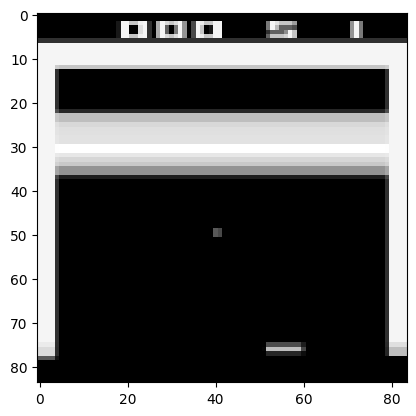

In [ ]:
plt.imshow(frame[0], cmap='gray')

In [ ]:
frame = np_to_pytorch_img(frame).to(device)
frame.shape

torch.Size([72, 1, 84, 84])

# Optimiser

In [ ]:
opt = torch.optim.Adam(agent.parameters(), lr=lr, eps=1e-5)

# Actor Critic with PPO
- Gathering trajectories
- Learning from the trajectories

### Generalised Advantage Estimation (GAE)

In [ ]:
def compute_returns_gae(rewards, dones, values):
    """ Compute discounted returns w Generalized Advantage Estimation (GAE) """

    #print(f"rewards shape: {rewards.shape}")
    #print(f"rewards type: {type(rewards)}")
    #print(f"dones shape: {dones.shape}")
    #print(f"rewards type: {type(rewards)}")
    #print(f"values shape: {values.shape}")
    #print(f"rewards type: {type(rewards)}")

    GAMMA = .999
    if is_dynamic_heads_model:
      LAM = 1.0 # Setting from dynamic heads paper
    else:
      LAM = .95 # Adjusting to this to make use of GAE. Setting lamdba to 1 means that all future rewards are calculated equally, as with standard Advantage function

    lastgaelam = 0
    A = [np.zeros(rewards.shape[-1])]
    for t in reversed(range(0, len(rewards)-1)):
        nextnonterminal = 1.0 - dones[t]
        nextvalues = values[t+1]
        delta = rewards[t] + GAMMA * nextvalues * nextnonterminal - values[t]
        lastgaelam = delta + GAMMA * LAM * nextnonterminal * lastgaelam
        A.append(lastgaelam)
    A.reverse()
    A = np.array(A)
    R = A + values
    return R


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Gather Trajectories

In [ ]:
def gather_trajectories():
    with torch.no_grad():
        agent.eval()
        global last_frame_
        frame = last_frame_
        #print(f"frame: {frame.shape}")
        frames_, rewards_, dones_, actions_, old_action_probs_, old_state_estimates_, epinfos = [], [], [], [], [], [], []
        attention_entropies = {1: [], 2: [], 3: [], 4: []}  #Dict to store entropy values for each attention head

        prev_action = None
        prev_reward = None

        for s in range(n_steps):
            #frames_.append(frame);
            frames_.append(resize_observations(frame, new_shape=(64, 64)));
            #resize_observations(last_frame_, new_shape=(64, 64))

            if is_attention_agent:
              action_probs, state_estimate, hidden_state, attention_maps = agent(np_to_pytorch_img(frame).to(device), prev_reward, prev_action);
              if not hidden_state == None:
                hx, cx = hidden_state
                history_hx.append(hx.squeeze(0).cpu().data.numpy())
                history_cx.append(cx.squeeze(0).cpu().data.numpy())
            else:
              action_probs, state_estimate, hidden_state, attention_maps = agent(np_to_pytorch_img(frame).to(device));


            action = get_action(action_probs).cpu().numpy();
            frame, reward, done, info = env.step(action)
            frame = resize_observations(frame, new_shape=(64, 64))
            rewards_.append(reward); dones_.append(done); actions_.append(action); old_action_probs_.append(action_probs.detach().cpu().numpy()); old_state_estimates_.append(state_estimate.detach().cpu().numpy())

            prev_action = action
            prev_reward = reward

            for i in info:
                episode_info = i.get('episode')
                if episode_info: epinfos.append(episode_info)

            if is_attention_agent and not attention_maps == None:
              for i, attention_map in enumerate(attention_maps, 1):

                  #print(f"i : {i}")
                  attention_map_np = attention_map.cpu().data.numpy()
                  entropy = calculate_entropy(attention_map_np)
                  #print(f"attention_map_np: {attention_map_np.shape}")
                  #Attention weights for each head
                  #Append attention weights to corresponding attention head list
                  if i == 1:
                      attention_head_1.append(attention_map.cpu().data.numpy())
                      #print(f"attention_map {attention_map.cpu().shape}")
                      attention_entropies[1].append(entropy)
                  elif i == 2:
                      attention_head_2.append(attention_map.cpu().data.numpy())
                      attention_entropies[2].append(entropy)
                  elif i == 3:
                      attention_head_3.append(attention_map.cpu().data.numpy())
                      attention_entropies[3].append(entropy)
                  elif i == 4:
                      attention_head_4.append(attention_map.cpu().data.numpy())
                      attention_entropies[4].append(entropy)

        rewards_ = np.array(rewards_); dones_ = np.array(dones_); actions_ = np.array(actions_); frames_ = np.array(frames_); old_state_estimates_ = np.array(old_state_estimates_);

        last_frame_ = frames_[-1] # reset global last frame. Next time we gather trajectories we'll pick up here

        rewards_[-1] = state_estimate.squeeze(-1).cpu().numpy() # Bootstrapped returns

        returns_ = compute_returns_gae(rewards_, dones_, old_state_estimates_.squeeze(-1))

        # Reshaping dims and prepping tensor types and locations. Nothing conceptually interesting.
        returns_, old_state_estimates_, old_action_probs_, actions_, frames_ = reshaping_processing_acrobatics(returns_, old_state_estimates_, old_action_probs_, actions_, frames_)

        return returns_, frames_, actions_, old_action_probs_, old_state_estimates_, epinfos, attention_entropies

In [ ]:
last_frame_ = env.reset(); last_frame_.shape #(n_envs, height, width, channels)
last_frame_ = resize_observations(last_frame_, new_shape=(64, 64))

In [ ]:
#Creating a global database of rollouts
returns, frames, actions, old_action_probs, old_state_estimates, epinfos, _ = gather_trajectories()
returns.shape, frames.shape, actions.shape

(torch.Size([18432]), torch.Size([18432, 1, 84, 84]), torch.Size([18432]))

In [ ]:
def get_batch(batch_ix):
    return frames[batch_ix].to(device), returns[batch_ix].to(device), actions[batch_ix].to(device), old_action_probs[batch_ix].to(device), old_state_estimates[batch_ix].to(device)

## Action Gain

In [ ]:
def calculate_action_gain_ppo(action_probs, old_action_probs, actions_taken, advantages, verbose=False):
    """ Actions resulting in positive advantage made more probable, and vice versa. Do not allow to differ from old
    probs by too much. Log probs are from current agent. Actions_taken are from OLD version of agent. """

    a = actions_taken.unsqueeze(-1).to(device)
    if verbose: print("\n\nactions unsqueezed\n", a)

    chosen_action_probs = action_probs.gather(1, a)
    chosen_action_probs = chosen_action_probs.squeeze(-1)

    old_chosen_action_probs = old_action_probs.gather(1, a)
    old_chosen_action_probs = old_chosen_action_probs.squeeze(-1)
    if verbose: print("\n\nchosen action probs, new and old\n", chosen_action_probs,'\n', old_chosen_action_probs, '\n\nadvantages values', advantages)

    ratio = torch.exp(chosen_action_probs - old_chosen_action_probs)
    if verbose: print('\n\nratio', ratio)

    unclipped_action_gain = ratio * advantages
    clipped_action_gain = torch.clamp(ratio, .8, 1.2) * advantages
    if verbose: print('\n\nunclipped and clipped action gains\n', unclipped_action_gain, '\n', clipped_action_gain)

    action_gain = torch.min(unclipped_action_gain, clipped_action_gain)
    if verbose: print('\n\n conservative lower bound action gain\n', action_gain)

    action_gain = action_gain.mean()
    if verbose: print('\n\nmean', action_gain)

    return action_gain # single scalar

## Critic Loss

In [ ]:
def get_critic_loss(old_state_estimates_b, state_estimates, returns_b, verbose=False):
    """ How good is critic at estimating state? Don't allow to differ too much from old state estimates """

    state_estimates = state_estimates.squeeze(-1)
    clipped_state_estimate = old_state_estimates_b + torch.clamp(state_estimates - old_state_estimates_b, -.2, .2)
    if verbose: print("\nstate estimates, new and old\n\n", state_estimates, '\n', old_state_estimates_b, '\n\nreturns', returns_b)
    critic_loss_1 = ((returns_b - clipped_state_estimate)**2)
    critic_loss_2 = ((returns_b - state_estimates)**2)
    critic_loss = torch.max(critic_loss_1, critic_loss_2)
    if verbose: print('\nCritic Losses: clipped, unclipped, conservative:\n', critic_loss_1, '\n', critic_loss_2, '\n', critic_loss)
    critic_loss = critic_loss.mean() * .5
    return critic_loss # single scalar

## Entropy Term

In [ ]:
def get_entropy_bonus(action_probs):
    e = -(action_probs.exp() * (action_probs+1e-8))
    e = e.sum(dim=1)
    e = e.mean()
    return e

In [ ]:
def run_batch(batch_ix, verbose=False, prev_reward=None, prev_action=None):
    """
    Run a single batch of data. Takes in indices, uses them to pull from global database of rollouts,
    calculates and returns losses. No gradient steps here.
    """

    frames_b, returns_b, actions_taken_b, old_action_probs_b, old_state_estimates_b = get_batch(batch_ix)

    action_probs, state_estimates, _, _ = agent(frames_b)
    entropy_bonus = get_entropy_bonus(action_probs)
    critic_loss = get_critic_loss(old_state_estimates_b, state_estimates, returns_b, verbose=verbose)

    with torch.no_grad():
        advantages = (returns_b - state_estimates.squeeze(-1).detach()) # don't want to propogate gradients through this
        advantages -= advantages.mean()
        advantages /= (advantages.std() + 1e-8)

    action_gain = calculate_action_gain_ppo(action_probs, old_action_probs_b, actions_taken_b, advantages, verbose=verbose)

    return entropy_bonus, action_gain, critic_loss, frames_b, returns_b, actions_taken_b

## Learn from Current Trajectories

In [ ]:
def reflect(verbose=False):
    """ Learn from current database of rollouts for a single epoch """

    agent.train()
    epoch_losses = []
    ix_range = range(len(returns))
    ix = 0
    grad_accum_counter = 1

    prev_action = None
    prev_reward = None

    while ix < len(returns):
        batch_ix = ix_range[ix:ix+bs]; ix += bs
        entropy_bonus, action_gain, critic_loss, frames_b, prev_reward, prev_action = run_batch(batch_ix, verbose=verbose, prev_reward=prev_reward, prev_action=prev_action)
        entropy_bonus *= entropy_coef
        critic_loss *= value_loss_coef
        if verbose: print("\n\nentropy bonus, action gain\n, critic loss\n", entropy_bonus.item(), action_gain.item(), critic_loss.item())
        total_loss = critic_loss - entropy_bonus - action_gain
        total_loss /= accumulation_steps
        total_loss.backward()

        if grad_accum_counter % accumulation_steps == 0:
            nn.utils.clip_grad_norm_(agent.parameters(), .5);
            opt.step()
            opt.zero_grad()

        grad_accum_counter+=1
        epoch_losses.append(total_loss.item())
        entropies.append(entropy_bonus.item())
        entropy_coefs.append(entropy_coef)
        policy_losses.append(action_gain.item())
        value_losses.append(critic_loss.item())
        a2c_losses.append(total_loss.item())

        #Log to CSV
        log_to_csv(len(epoch_losses), entropy_bonus.item(), action_gain.item(), critic_loss.item(), total_loss.item(), None, None)

    return np.array(epoch_losses).mean(); # epoch avg loss

reflect(False)

0.2185134571045637

In [ ]:
def shuffle_database():
    """ Shuffle the global database of rollouts in place. Doesn't return anything. Requires that database exist. """
    global returns, frames, actions, old_action_probs, old_state_estimates
    dataset_ix = torch.randperm(len(returns));
    returns = returns[dataset_ix]
    frames = frames[dataset_ix]
    actions = actions[dataset_ix]
    old_action_probs = old_action_probs[dataset_ix]
    old_state_estimates = old_state_estimates[dataset_ix]

# Training



In [ ]:
if save_attention_map_before_training:
    if is_attention_agent:
      generate_attention_maps(env_name,
                              first_frame=100,
                              num_frames=400,
                              resolution=50,
                              save_dir=logs_dir_path + "/saved_attention_videos")

In [ ]:
head1_entropies, head2_entropies, head3_entropies, head4_entropies = [], [], [], []

scores = []; losses = [];

steps_so_far = 0
last_save_frame = 0
print(f"Env Name: {env_name}\n")
#print(f"n_opt_epochs: {n_opt_epochs}\n" )

if is_dynamic_heads_model:
  print("Dynamic Heads Model\n")

if not is_attention_agent and not is_dynamic_heads_model:
  print("Vanilla IMPALA Model\n")
else:
  print("Attention Augmented Model")
  print(f"Attention maps printed every {save_attention_map_interval} frames\n")

print(f"Number of steps per trajectory: {n_steps}" )
print(f"Number of trajectories per round: {n_envs}")
print(f"Total steps per round: {n_obs_per_round}\n" )
print(f"Total number of rounds: {n_rounds}\n" )

print(f"Total number of steps: {target_n_obs}\n")


print(f"Entropy Coef: {entropy_coef}")
print(f"Value Loss Coef: {value_loss_coef}")
print(f"LR: {lr}")
print(f"\n")

if enable_entropy_decay:
  print(f"Entropy Decay type: {entropy_decay_type}")
  print(f"Start decay: {entropy_coef_start}")
  print(f"End decay: {entropy_coef_end}")
  print(f"\n")

for i in range(n_rounds):

    if enable_entropy_decay:
      entropy_coef = adjust_entropy_coef(entropy_coef, i, n_rounds)
      print(f"Entropy Coef: {entropy_coef}")

    print(f"\nRound {i}")

    attention_head_1, attention_head_2, attention_head_3, attention_head_4 =[],[],[],[]
    #history_hx, history_cx = [], []

    steps_so_far = n_obs_per_round * i
    print(f"Steps so far: {steps_so_far}")
    with torch.no_grad():
        returns, frames, actions, old_action_probs, old_state_estimates, epinfos, attention_entropies = gather_trajectories() # refresh 'database'
        avg_score = get_avg_score(epinfos)
        scores.append(avg_score)

        if is_attention_agent:

          mean_entropies = calculate_mean_entropies(attention_entropies)

          head1_entropies.append(mean_entropies[1])
          head2_entropies.append(mean_entropies[2])
          head3_entropies.append(mean_entropies[3])
          head4_entropies.append(mean_entropies[4])

          #save_entropies(mean_entropies)

          #Check if steps_so_far has crossed a multiple of 240000 since last save
          if steps_so_far // save_attention_map_interval > last_save_frame // save_attention_map_interval:
              #Update last save frame
              last_save_frame = steps_so_far
              save_path = os.path.join(logs_dir_path, "saved_attention")
              os.makedirs(save_path, exist_ok=True)

              generate_attention_maps(env_name,
                                          first_frame=100,
                                          num_frames=400,
                                          resolution=50,
                                          save_dir=save_path,
                                          current_frame=steps_so_far)
              print(f"\n Generated Attention Maps\n")

    for e in range(n_opt_epochs):
        shuffle_database()
        loss = reflect(verbose = False)
        losses.append(loss)

    update_last_csv_line(avg_score, loss)

    #if i % 100 == 0: print(i, avg_score)
    print(i, avg_score)

Env Name: Breakout-v4

Vanilla IMPALA Model

Number of steps per trajectory: 256
Number of trajectories per round: 72
Total steps per round: 18432

Total number of rounds: 1

Total number of steps: 20000

Entropy Coef: 0.01
Value Loss Coef: 0.5
LR: 0.0005


Entropy Decay type: logarithmic
Start decay: 0.01
End decay: 0.001


Entropy Coef: 0.010000000000000002

Round 0
Steps so far: 0


KeyboardInterrupt: 

In [ ]:
torch.save(agent.state_dict(), logs_dir_path + "/" + env_name +"_agent.torch")

# Results

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

#Generate x axis values based on the total number of obs
x_values = [i * n_obs_per_round for i in range(len(scores))]

plt.plot(x_values, scores)
plt.title("Rewards " + env_name)
plt.xlabel("Steps")
plt.ylabel("Returns")

plt.show()

In [ ]:
plt.plot(range(len(scores)), scores)
plt.title("Scores " + env_name)

### Manually Inspect Performance

In [ ]:
with torch.no_grad():
    returns, frames, actions, old_action_probs, old_state_estimates, epinfos, attention_entropies = gather_trajectories()

returns.shape, frames.shape

### Generate Attention Maps After Training

In [ ]:
#attention_mask = torch.tensor([True, True, True, True, True, True, True, True], dtype=torch.bool)
#set_attention_mask(attention_mask)
if is_attention_agent:
  generate_attention_maps(env_name,
                          first_frame=100,
                          num_frames=400,
                          resolution=50,
                          save_dir=logs_dir_path + "/after_training_saved_attention_videos")

In [ ]:
n_vid_steps = 1000

### Actual Returns vs Estimated Returns

In [ ]:
if is_attention_agent:
  plt.figure(figsize=(20,5))
  plt.plot(range(len(returns[:n_vid_steps])), returns[:n_vid_steps])
  plt.plot(range(len(returns[:n_vid_steps])), old_state_estimates[:n_vid_steps])
  plt.title("Actual Returns vs Estimated Returns")
  plt.legend(["Actual", "Estimated"])
  plt.savefig(os.path.join(logs_dir_path, "actual_v_estimated_returns.png"))

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

frames_np = frames[:n_vid_steps].numpy()
returns_vid = returns[:n_vid_steps].numpy()

returns_vid -= returns_vid.min()
returns_vid /= returns_vid.max()

scale_factor = 20
height, width, layers = 84, 84, 3 # Original frame dimensions and number of color channels
new_height, new_width = height * scale_factor, width * scale_factor # Scaled dimensions
fps = 10

fig, ax = plt.subplots(figsize=(new_width/100, new_height/100), dpi=100)

def update_frame(i):
    frame = frames_np[i]
    frame = np.transpose(frame, (1, 2, 0))
    frame = np.uint8(frame * 255)
    return_value = returns_vid[i]

    frame[:5, :5, :] = 255 * return_value

    frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

    ax.clear()
    ax.imshow(frame)
    ax.axis('off')

ani = animation.FuncAnimation(fig, update_frame, frames=n_vid_steps, interval=1000/fps)

video_filename = logs_dir_path + "/" +env_name + '_agent_run.mp4'
ani.save(video_filename, writer='ffmpeg', fps=fps)

plt.close(fig)

### Plot Results

In [ ]:
train_step_interval = [i * n_obs_per_round for i in range(1, len(scores) + 1)]

plt.figure(figsize=(12, 8))
plt.plot(train_step_interval, head1_entropies, label='Head 1')
plt.plot(train_step_interval, head2_entropies, label='Head 2')
plt.plot(train_step_interval, head3_entropies, label='Head 3')
plt.plot(train_step_interval, head4_entropies, label='Head 4')

plt.xlabel('Steps')
plt.ylabel('Attetnion head Entropy')
plt.title('Entropies of Attention Heads Over Time')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(logs_dir_path, "attention_head_entropies.png"))
plt.show()

In [ ]:
sns.set(style="darkgrid")
train_step_interval = [i * n_obs_per_round for i in range(1, len(scores) + 1)]

plt.figure(figsize=(12, 8))
plt.plot(train_step_interval, scores)
plt.xlabel('Steps')
plt.ylabel('Training Reward')
plt.title('Training Reward over Time')
plt.savefig(os.path.join(logs_dir_path, "training_reward.png"))
plt.show()
'''
evaluation_steps = [i * evaluation_step_interval for i in range(1, len(eval_rewards) + 1)]

plt.figure(figsize=(12, 8))
plt.plot(evaluation_steps, eval_rewards)
plt.xlabel('Steps')
plt.ylabel('Evaluation Reward')
plt.title('Evaluation Reward over Time')
plt.savefig(os.path.join(logs_dir_path, "evaluation_reward.png"))
plt.show()
'''

plt.figure(figsize=(12, 8))
#plt.plot(train_step_interval, entropies)
plt.plot(entropies)
plt.xlabel('Steps')
plt.ylabel('Entropy')
plt.title('Entropy over Time')
plt.savefig(os.path.join(logs_dir_path, "entropy.png"))
plt.show()

plt.figure(figsize=(12, 8))
#plt.plot(train_step_interval, entropies)
plt.plot(entropy_coefs)
plt.xlabel('Steps')
plt.ylabel('Entropy Coef')
plt.title('Entropy Coef over Time')
plt.savefig(os.path.join(logs_dir_path, "entropy_coef.png"))
plt.show()

plt.figure(figsize=(12, 8))
#plt.plot(train_step_interval, value_losses)
plt.plot(value_losses)
plt.xlabel('Steps')
plt.ylabel('Value Loss')
plt.title('Value Loss over Time')
plt.savefig(os.path.join(logs_dir_path, "value_loss.png"))
plt.show()

plt.figure(figsize=(12, 8))
#plt.plot(train_step_interval, policy_losses)
plt.plot(policy_losses)
plt.xlabel('Steps')
plt.ylabel('Policy Loss')
plt.title('Policy Loss over Time')
plt.savefig(os.path.join(logs_dir_path, "policy_loss.png"))
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(a2c_losses)
#plt.plot(train_step_interval, a2c_losses)
plt.xlabel('Steps')
plt.ylabel('A2C Loss')
plt.title('A2C Loss over Time')
plt.savefig(os.path.join(logs_dir_path, "a2c_loss.png"))
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(train_step_interval, head1_entropies, label='Head 1 Entropies')
plt.plot(train_step_interval, head2_entropies, label='Head 2 Entropies')
plt.plot(train_step_interval, head3_entropies, label='Head 3 Entropies')
plt.plot(train_step_interval, head4_entropies, label='Head 4 Entropies')

plt.xlabel('Steps')
plt.ylabel('Attetnion head Entropy')
plt.title('Entropies of Attention Heads Over Time')
plt.legend()
plt.grid(True)
plt.show()

Copy the folders to google drive

In [ ]:
copy_folders_to_drive(src_directory, "content/log/")
print("Folders have been successfully copied to Google Drive.")

## Zip Experiment Results

In [ ]:
import os
import zipfile

def zip_directory(directory_path, output_zip_path):
    with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(directory_path):
            for file in files:
                full_path = os.path.join(root, file)
                arcname = os.path.relpath(full_path, directory_path)
                zipf.write(full_path, arcname)
    print(f"Directory '{directory_path}' has been successfully zipped to '{output_zip_path}'")

directory_to_zip = '/path/to/directory'
output_zip_file = '/path/to/output.zip'

zip_directory(src_directory, f"content/{experiment_name}.zip")